In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout,MaxPool2D, LSTM, GRU, BatchNormalization,Input
from tensorflow.keras.layers import Embedding, concatenate, Reshape,Activation
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import ELU


from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
data = pd.read_csv('../input/paddy-disease-classification/train.csv')
data.shape

(10407, 4)

In [3]:
data.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


# Data description
* image_id - Unique image identifier corresponds to image file names (.jpg) found in the train_images directory.
* label - Type of paddy disease, also the target class. There are ten categories, including the normal leaf.
* variety - The name of the paddy variety.
* age - Age of the paddy in days.

In [4]:
data.label.unique()

array(['bacterial_leaf_blight', 'bacterial_leaf_streak',
       'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart',
       'downy_mildew', 'hispa', 'normal', 'tungro'], dtype=object)

In [5]:
num_class = len(data.label.unique())
display("Number of classes:",num_class)

'Number of classes:'

10

In [6]:
img_rows, img_cols = 256, 256
batch_size = 64

# EDA

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  10407 non-null  object
 1   label     10407 non-null  object
 2   variety   10407 non-null  object
 3   age       10407 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 325.3+ KB


In [8]:
data['label'] = data['label'].astype('str')
data['variety'] = data['variety'].astype('str')

In [9]:
data.describe()

,age
count,10407.000000
mean,64.043624
std,8.958830
min,45.000000
25%,60.000000
50%,67.000000
75%,70.000000
max,82.000000


**Observation**

* The Average age of the paddy is 64 days.
* 75% of the dataset lie under age of 70 days.

**Paddy Disease distribution in the Dataset**

In [10]:
data['label'].value_counts()

normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: label, dtype: int64

In [11]:
percent = data['label'].value_counts() / len(data) * 100
print(percent)

normal                      16.950130
blast                       16.700298
hispa                       15.316614
dead_heart                  13.856058
tungro                      10.454502
brown_spot                   9.272605
downy_mildew                 5.957529
bacterial_leaf_blight        4.602671
bacterial_leaf_streak        3.651388
bacterial_panicle_blight     3.238205
Name: label, dtype: float64


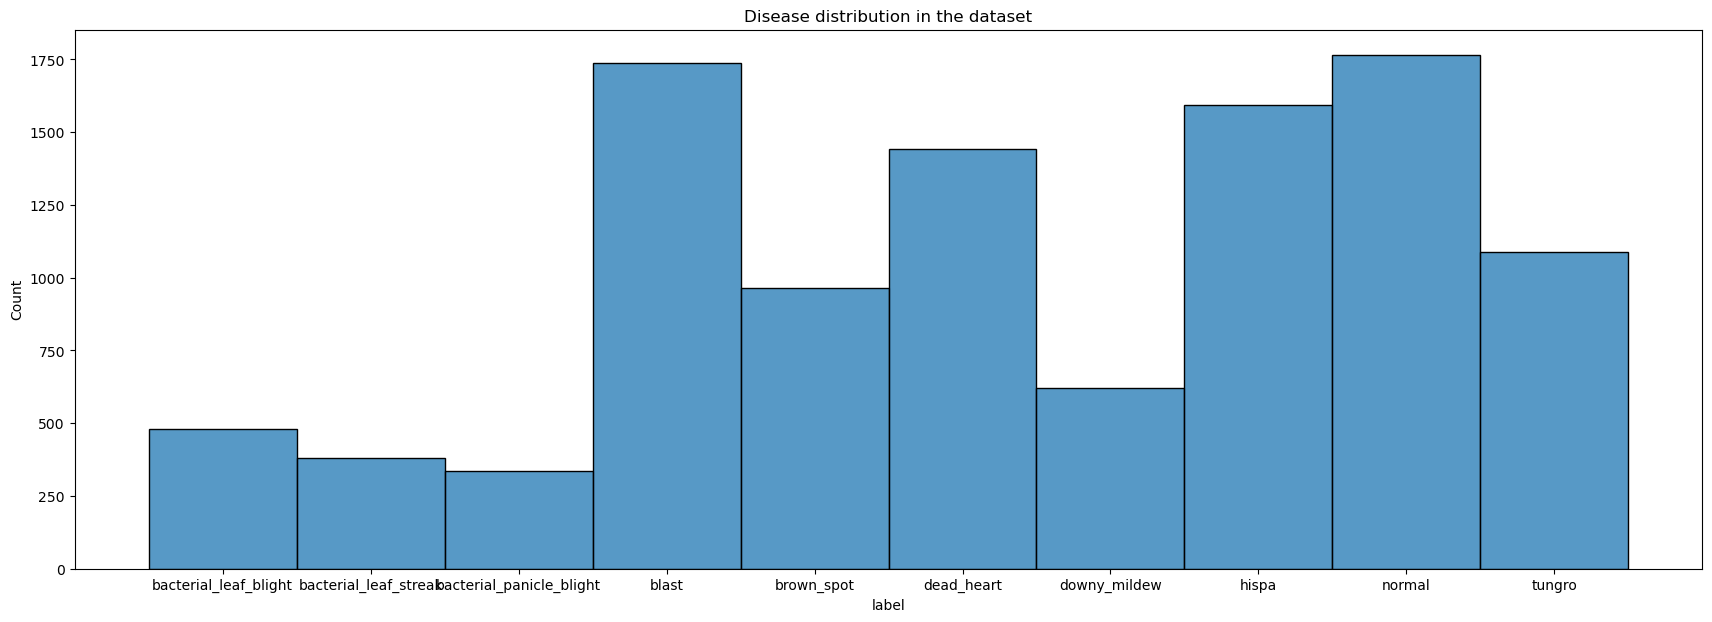

In [12]:
fig,axes = plt.subplots(1,1,figsize=(21,7))
sns.histplot(data,x='label',bins=10,ax=axes)
plt.title('Disease distribution in the dataset')
plt.show()

**Paddy Variety distribution in the Dataset**

In [13]:
data['variety'].value_counts()

ADT45             6992
KarnatakaPonni     988
Ponni              657
AtchayaPonni       461
Zonal              399
AndraPonni         377
Onthanel           351
IR20               114
RR                  36
Surya               32
Name: variety, dtype: int64

In [14]:
percent = data['variety'].value_counts() / len(data) * 100
print(percent)

ADT45             67.185548
KarnatakaPonni     9.493610
Ponni              6.313059
AtchayaPonni       4.429711
Zonal              3.833958
AndraPonni         3.622562
Onthanel           3.372730
IR20               1.095417
RR                 0.345921
Surya              0.307485
Name: variety, dtype: float64


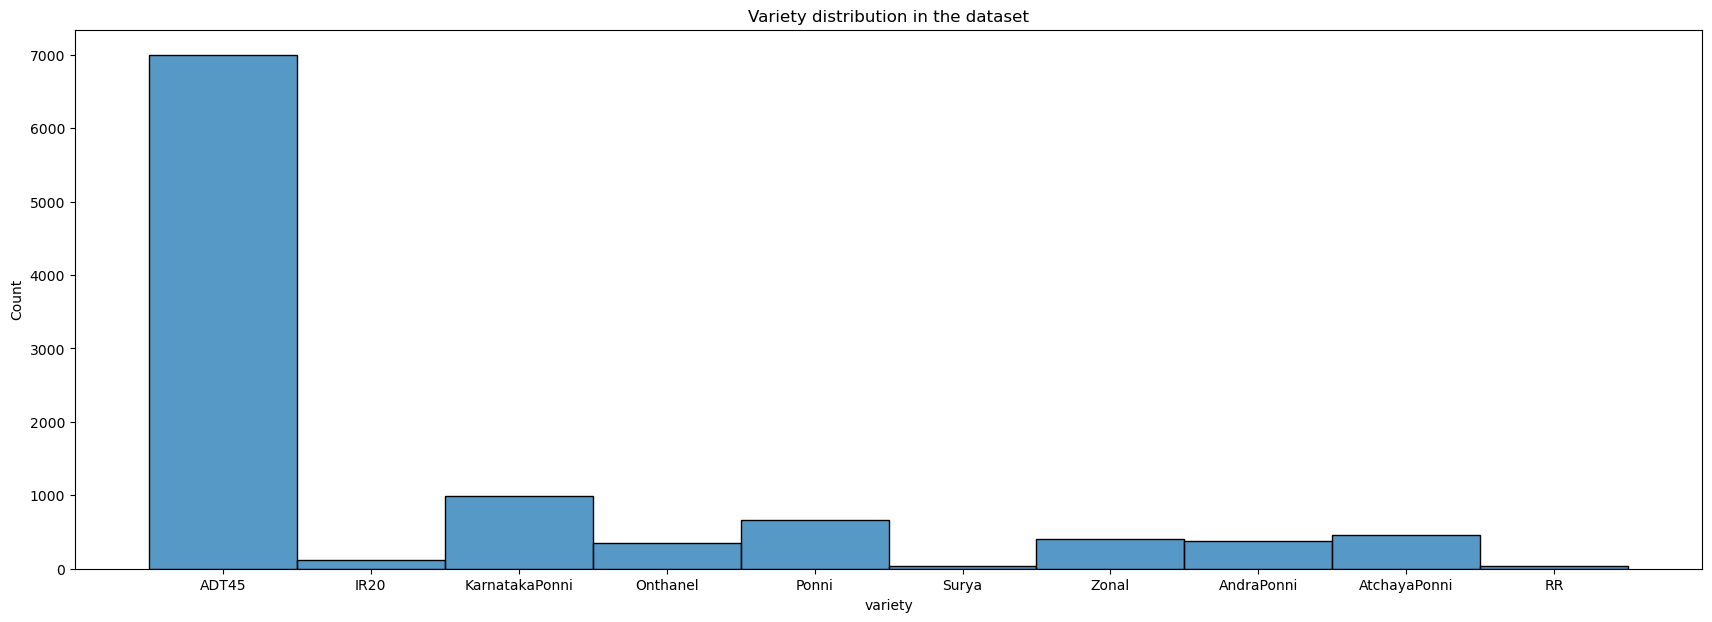

In [15]:
fig,axes = plt.subplots(1,1,figsize=(21,7))
sns.histplot(data,x='variety',ax=axes)
plt.title('Variety distribution in the dataset')
plt.show()

**Paddy diseases visualizing**

In [16]:
images = ['../input/paddy-disease-classification/train_images/hispa/106590.jpg',\
          '../input/paddy-disease-classification/train_images/tungro/109629.jpg',\
          '../input/paddy-disease-classification/train_images/bacterial_leaf_blight/109372.jpg',\
          '../input/paddy-disease-classification/train_images/downy_mildew/102350.jpg',\
          '../input/paddy-disease-classification/train_images/blast/110243.jpg',\
          '../input/paddy-disease-classification/train_images/bacterial_leaf_streak/101104.jpg',\
          '../input/paddy-disease-classification/train_images/normal/109760.jpg',\
          '../input/paddy-disease-classification/train_images/brown_spot/104675.jpg',\
          '../input/paddy-disease-classification/train_images/dead_heart/105159.jpg',\
          '../input/paddy-disease-classification/train_images/bacterial_panicle_blight/101351.jpg',\
         ]
diseases = ['hispa','tungro','bacterial_leaf_blight','downy_mildew','blast','bacterial_leaf_streak',\
           'normal','brown_spot','dead_heart','bacterial_panicle_blight']
diseases = [disease +' disease' for disease in diseases]

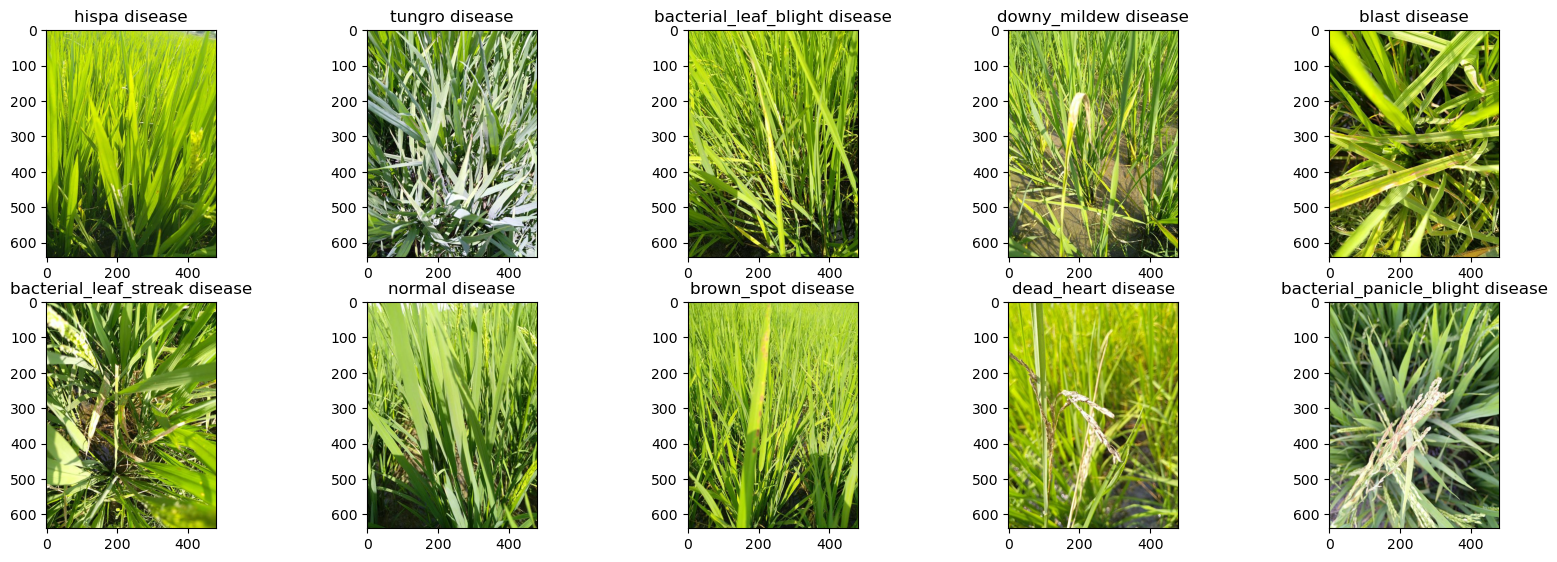

In [17]:
plt.figure(figsize=(20,10))
columns = 5
for i, image_loc in enumerate(images):
    plt.subplot(len(images)//columns + 1, columns, i + 1)
    image=plt.imread(image_loc)
    plt.title(diseases[i])
    plt.imshow(image)

# Data Augmentation

In [18]:
# use data augmentation to improve accuracy and prevent overfitting
aug_gens = ImageDataGenerator(
    rescale=1.0/255.0,
    featurewise_center=False,  
    samplewise_center=False, 
    featurewise_std_normalization=False,  
    samplewise_std_normalization=False,  
    zca_whitening=False,  
    validation_split=0.1,
    rotation_range=10,
    shear_range=0.25,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
)

In [19]:
train_loc = '../input/paddy-disease-classification/train_images/'
train_data = aug_gens.flow_from_directory(
    train_loc,
    subset="training",
    seed=2,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode="categorical")

Found 9371 images belonging to 10 classes.


In [20]:
valid_data = aug_gens.flow_from_directory(
    train_loc,
    subset="validation",
    seed=2,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode="categorical")

Found 1036 images belonging to 10 classes.


In [21]:
test_loc = '../input/paddy-disease-classification/test_images'
test_data = ImageDataGenerator(rescale=1.0/255).flow_from_directory(    
    directory=test_loc,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    classes=['.'],
    shuffle=False,
)

Found 3469 images belonging to 1 classes.


In [22]:
print(train_data.class_indices)
print(len(train_data.class_indices))

{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}
10


**LEAKY RELU**

In [23]:
leakyrelu = tf.keras.layers.LeakyReLU(alpha=0.01)


[-2.68280104e-03 -6.37735836e-03 -1.48357389e-02 -3.34642546e-02
 -7.19448398e-02 -1.42277620e-01 -2.38405844e-01 -2.68941421e-01
  0.00000000e+00  7.31058579e-01  1.76159416e+00  2.85772238e+00
  3.92805516e+00]


<function matplotlib.pyplot.show(close=None, block=None)>

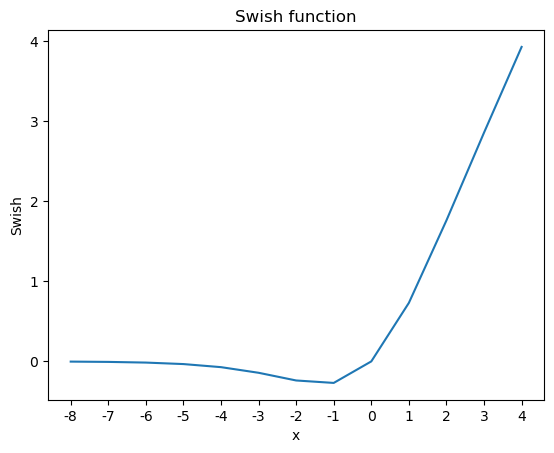

In [24]:
x = np.arange(-8,5)
swish = x/(1+np.exp(-x))
print(swish)
pd.Series(swish).plot(kind='line')
plt.title('Swish function')
plt.xticks(range(len(x)),x)
plt.ylabel('Swish')
plt.xlabel('x')
plt.show

# Build Model

**Baseline model**

In [25]:
input_layer = Input((img_rows,img_cols,3))
conv2d_1_1 = Conv2D(filters=16, kernel_size=3,strides =(1,1), activation='relu', padding="same", name ="conv2d_branch1")(input_layer)
maxpool = MaxPool2D(pool_size=[2,2])(conv2d_1_1)

conv2d_1_2 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding="same")(maxpool)
maxpool = MaxPool2D(pool_size=[2,2])(conv2d_1_2)

conv2d_1_3 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding="same")(maxpool)
maxpool = MaxPool2D(pool_size=[2,2])(conv2d_1_3)

conv2d_1_4 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding="same")(maxpool)
maxpool = MaxPool2D(pool_size=[2,2])(conv2d_1_4)

flatten = Flatten()(maxpool)
dense_1 = Dense(1024, activation='swish')(flatten)
dense_2 = Dense(128, activation='swish')(dense_1)

output_dense = Dense(num_class, activation="softmax")(dense_2)

model = Model(inputs=[input_layer], outputs=[output_dense])

**Resnet Architecture**

In [26]:
def conv_layer(input,filter=64,strides=2):
    conv_1 = Conv2D(filter, kernel_size=3,strides=strides ,padding='same',activation = 'relu',kernel_initializer = 'glorot_normal')(input)
    conv_2 = Conv2D(filter, kernel_size=3,strides=strides , padding='same',kernel_initializer = 'glorot_normal')(conv_1)
    bn     = BatchNormalization(axis=3)(conv_2)
    act    = Activation('relu')(bn)
    pool   = MaxPool2D((2,2))(act)
    return pool

In [27]:
def build_model():
    input  = Input((img_rows,img_cols,3))
    conv_1 = conv_layer(input,filter=16,strides=1)
    conv_2 = conv_layer(conv_1,filter=16,strides=1)
    pool = MaxPool2D((2,2))(conv_1)
    merge1 = concatenate([pool,conv_2], axis = 3)
    #pool = MaxPool2D((2,2))(merge1)
    
    conv_3 = conv_layer(merge1,filter=32,strides=1)
    conv_4 = conv_layer(conv_3,filter=32,strides=1)
    pool = MaxPool2D((2,2))(conv_3)
    merge2 = concatenate([pool,conv_4], axis = 3)
    #pool = MaxPool2D((2,2))(merge2)
    
    conv_5 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding="same") (merge2)
    pool = MaxPool2D(pool_size=[2,2])(conv_5)
    
    conv_6 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding="same")(pool)
    pool = MaxPool2D(pool_size=[2,2])(conv_6)
    
    dense  = Flatten()(pool)
    dense  = Dense(128,activation='relu')(dense)
    drop   = Dropout(0.4)(dense)
    dense  = Dense(64,activation='relu')(dense)
    output = Dense(num_class, activation='softmax')(drop)    

    model = Model(inputs=[input],outputs = [output])
    return model

model = build_model()

In [28]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_4 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d_3[0][0]']               
                                )                                                           

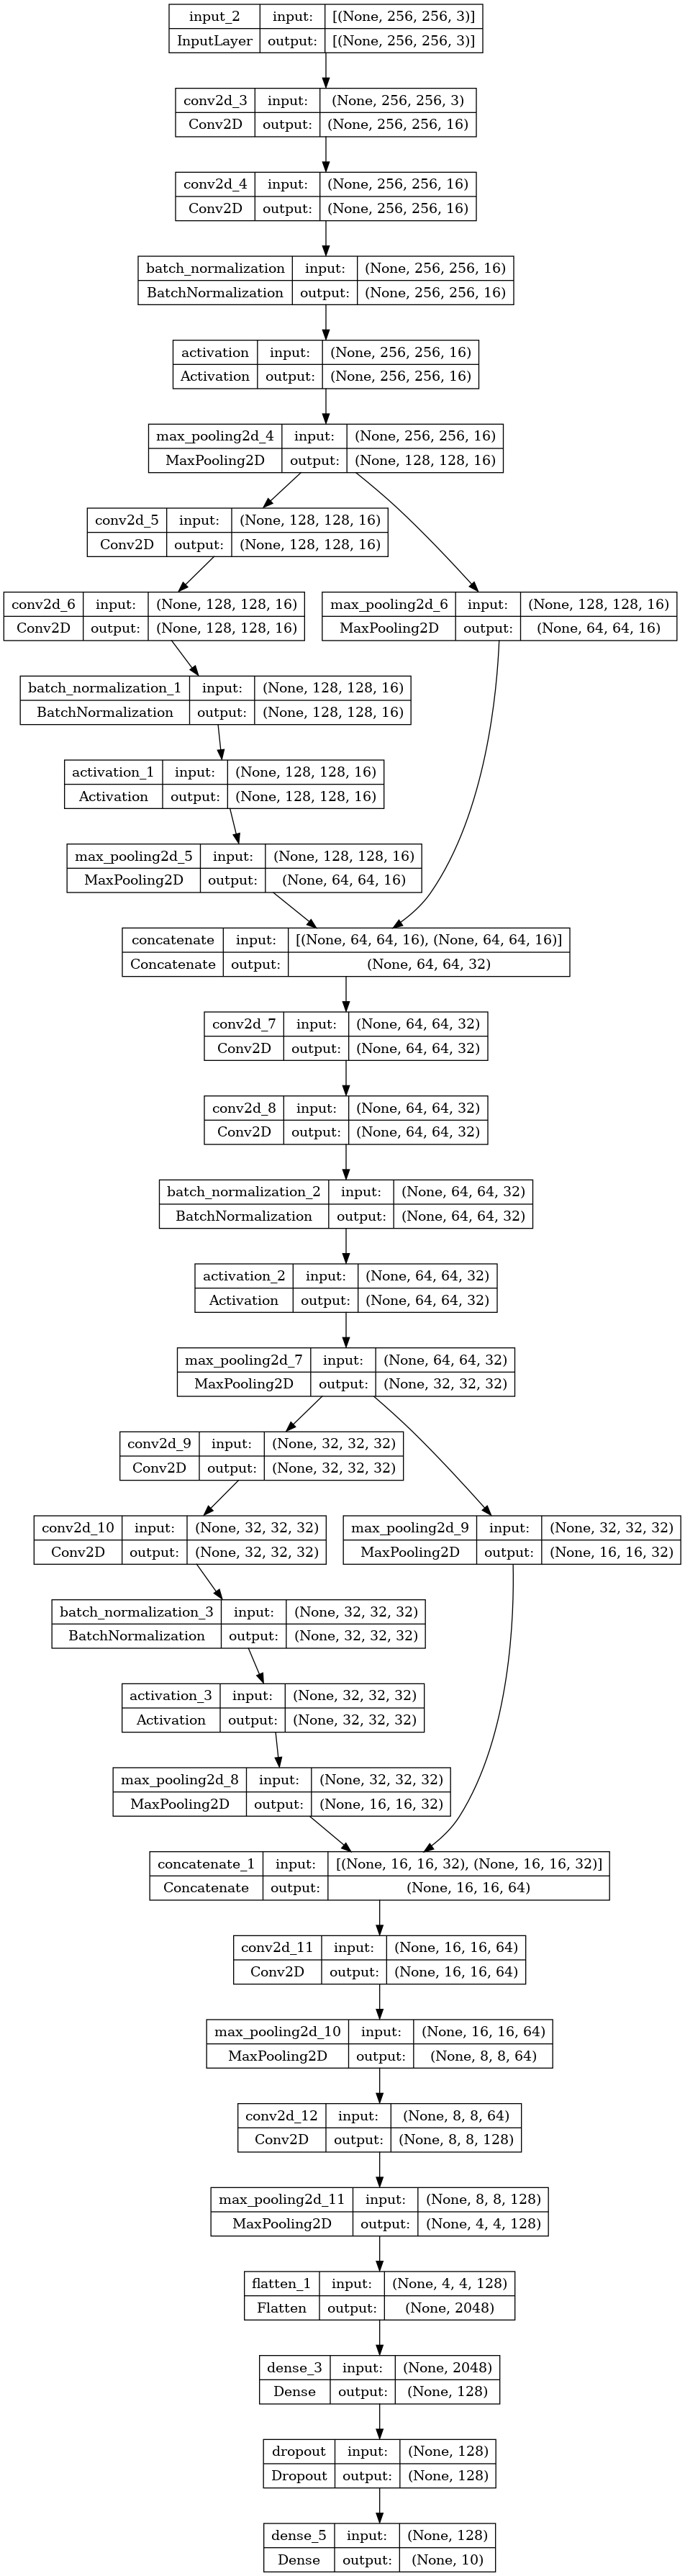

In [29]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
Image("model.png")

In [30]:
EPOCH = 60

lr_reduction = ReduceLROnPlateau(monitor='val_loss',patience=8, verbose=1,  factor=0.4, min_lr=0.0005)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=8, mode='auto', restore_best_weights=True, verbose=1)

checkpoint = ModelCheckpoint('model.hdf5', monitor='val_loss', save_best_only=True,verbose=1)

In [31]:
model.compile(optimizer= 'adam',loss=tf.losses.CategoricalCrossentropy(),metrics=['accuracy'])
model_fit = model.fit(train_data, epochs=EPOCH ,batch_size = batch_size ,validation_data=valid_data, verbose =1,callbacks=[checkpoint,lr_reduction])

Epoch 1/60
147/147 [==============================] - ETA: 0s - loss: 2.0178 - accuracy: 0.2983
Epoch 1: val_loss improved from inf to 2.60488, saving model to model.hdf5
147/147 [==============================] - 280s 2s/step - loss: 2.0178 - accuracy: 0.2983 - val_loss: 2.6049 - val_accuracy: 0.1535 - lr: 0.0010
Epoch 2/60
147/147 [==============================] - ETA: 0s - loss: 1.7008 - accuracy: 0.4089
Epoch 2: val_loss did not improve from 2.60488
147/147 [==============================] - 182s 1s/step - loss: 1.7008 - accuracy: 0.4089 - val_loss: 3.7024 - val_accuracy: 0.1525 - lr: 0.0010
Epoch 3/60
147/147 [==============================] - ETA: 0s - loss: 1.5721 - accuracy: 0.4581
Epoch 3: val_loss did not improve from 2.60488
147/147 [==============================] - 182s 1s/step - loss: 1.5721 - accuracy: 0.4581 - val_loss: 2.9898 - val_accuracy: 0.1708 - lr: 0.0010
Epoch 4/60
147/147 [==============================] - ETA: 0s - loss: 1.4820 - accuracy: 0.4864
Epoch 4: val

In [32]:
model.load_weights('model.hdf5')

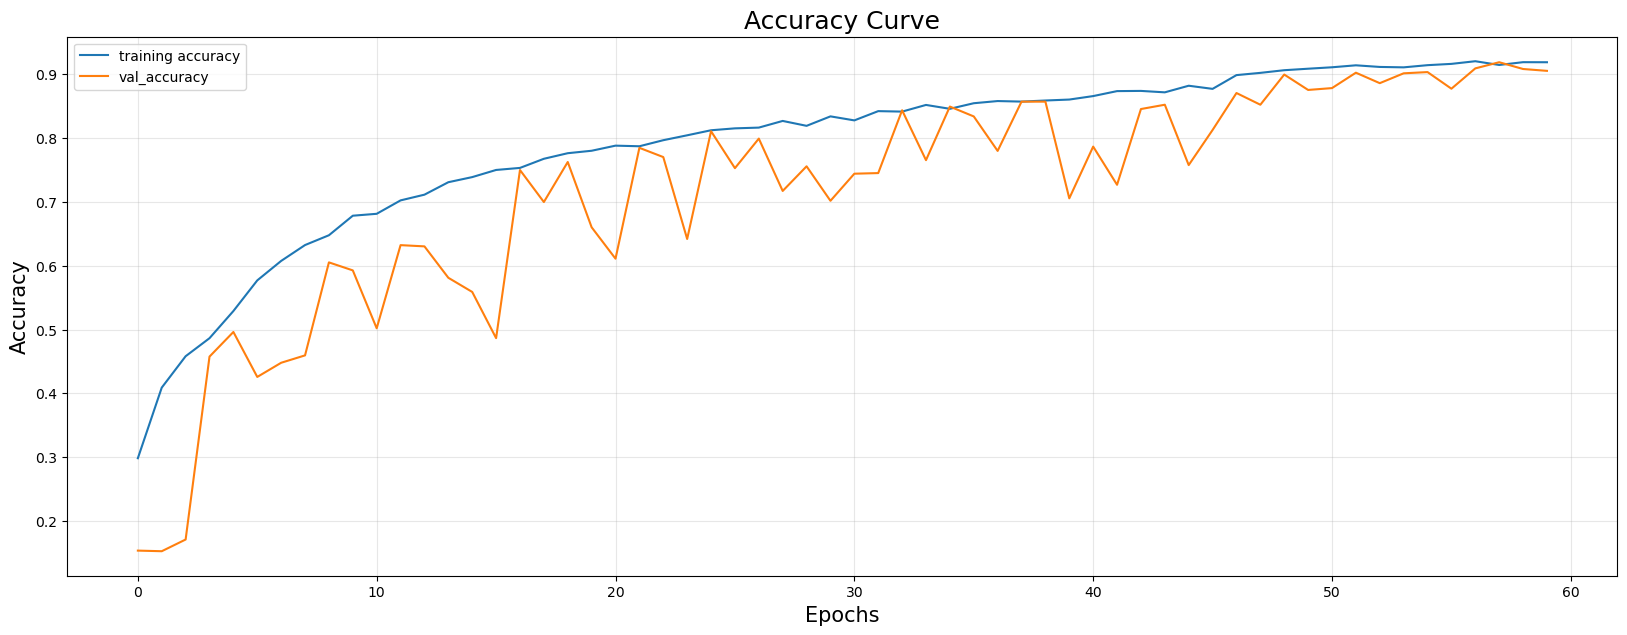

In [33]:
f = plt.figure(figsize=(20,7))

# For Accuracy
plt.plot(model_fit.epoch,model_fit.history['accuracy'],label = "training accuracy") # Accuracy curve for training set
plt.plot(model_fit.epoch,model_fit.history['val_accuracy'],label = "val_accuracy") # Accuracy curve for validation set

plt.title("Accuracy Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()